In [1]:
!date

Tue Jul 29 08:03:41 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

### Get Files

In [3]:
import os
import numpy as np
import pandas as pd
import ants

In [4]:
import importlib

import DeepCor_utils
importlib.reload(DeepCor_utils)

import DeepCor_models
importlib.reload(DeepCor_models)

from DeepCor_utils import *
from DeepCor_models import *

numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.6.1
numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.6.1


In [5]:
# Parameters for looping. 
s = 15 # index for subject (out of 14)
r = 2 # index for run (out of 4)
analysis_name = 'ABCD-baseline-test' # This is be appended to the saved output files 

In [6]:
indir = '../Data/020-fmriprepped'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs.sort()
print(f'{s}/{len(subs)}')
n_orig = len(subs)
sub = subs[s]
sub

15/34


'sub-NDARINVN9D4XZKE'

In [7]:
epi_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','func',f'{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
anat_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')
anat_gm_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz')
anat_wm_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-WM_probseg.nii.gz')
anat_csf_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-CSF_probseg.nii.gz')
conf_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','func',f'{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_desc-confounds_timeseries.tsv')
events_fn = os.path.join(f'../Data/011-ABCD-events/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv')

In [8]:
epi = ants.image_read(epi_fn.format(sub=sub,r=r))
anat = ants.image_read(anat_fn.format(sub=sub,r=r))
anat_gm = ants.image_read(anat_gm_fn.format(sub=sub,r=r))
anat_wm = ants.image_read(anat_wm_fn.format(sub=sub,r=r))
anat_csf = ants.image_read(anat_csf_fn.format(sub=sub,r=r))
df_conf = pd.read_csv(conf_fn,delimiter='\t')


In [9]:
## EPI parameters: Check that these are correct
nTR = epi.shape[-1]
t_r = round(epi.spacing[-1],2)
ndummy = 8

print(f'Number of scans: {nTR}')
print(f'Repetition Time: {t_r}')
print(f'Dummy scans to discard: {ndummy}')

Number of scans: 370
Repetition Time: 0.8
Dummy scans to discard: 8


In [10]:
# Directory where to save the outputs
ofdir_root = '../Data/StudyForrest/ensembles_last_CVAE'
ofdir = os.path.join(ofdir_root,analysis_name)
safe_mkdir(ofdir)
print(ofdir)

../Data/StudyForrest/ensembles_last_CVAE/ABCD-baseline-test


## Post-training analyses

In [11]:
events_fn = os.path.join(events_fn)
X1 = get_design_matrix(epi,events_fn)
X1

,0_back_negface,0_back_neutface,0_back_place,0_back_posface,2_back_negface,2_back_neutface,2_back_place,2_back_posface,cue,dummy,drift_1,drift_2,drift_3,constant
0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.50000,0.166215,-0.049594,1.0
0.8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000189,-0.49729,0.163512,-0.047981,1.0
1.6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006770,-0.49458,0.160824,-0.046391,1.0
2.4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041190,-0.49187,0.158151,-0.044821,1.0
3.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123477,-0.48916,0.155492,-0.043274,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292.0,-0.073161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.48916,0.155492,0.043274,1.0
292.8,-0.061770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.49187,0.158151,0.044821,1.0
293.6,-0.051029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.49458,0.160824,0.046391,1.0
294.4,-0.041240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.49729,0.163512,0.047981,1.0


In [12]:
# If no post-training analyses needed, leave these empty
correlation_analyses = []
contrast_analyses = []

In [13]:
correlation_analyses.append(
    {'corr_target' : X1[['0_back_negface','0_back_neutface','0_back_posface','2_back_neutface','2_back_posface']].values.mean(axis=1),
     'filename' : os.path.join(ofdir,f'corr2face_S{s}_R{r}.nii.gz'),
     'plot' : True, 
     'ROI' : '../Misc/ffa_mask_resampled.nii'
    })

correlation_analyses.append(
    {'corr_target' : X1[['0_back_place','2_back_place']].values.sum(axis=-1),
     'filename' : os.path.join(ofdir,f'corr2place_S{s}_R{r}.nii.gz'),
     'plot' : True,
     'ROI' : '../Misc/ppa_mask_resampled_97_115_97.nii.gz'
    })

contrast_analyses.append(
    {'contrast_vec' : [1,1,-3,1,1,1,-3,1,0,0,0,0,0,0],
     'design_matrix' : X1,
     'filename' : os.path.join(ofdir,f'contrast_face_{s}_R{r}.nii.gz'),
     'plot' : True, 
     'ROI' : '../Misc/ffa_mask_resampled.nii'
    })

contrast_analyses.append(
    {'contrast_vec' : [-1,-1,3,-1,-1,-1,3,-1,0,0,0,0,0,0],
     'design_matrix' : X1,
     'filename' : os.path.join(ofdir,f'contrast_place_S{s}_R{r}.nii.gz'),
     'plot' : True,
     'ROI' : '../Misc/ppa_mask_resampled_97_115_97.nii.gz'
    })

In [14]:
# Model Hyperparameters
hyperparams_cvae = {}
hyperparams_cvae['nrep'] = 20
hyperparams_cvae['epoch_num'] = 100
hyperparams_cvae['batch_size'] = 1024
hyperparams_cvae['latent_dim'] = 8 #(8,8) # Shared,Specific
hyperparams_cvae['beta'] = 0.01       
hyperparams_cvae['gamma'] = 1 # TC scaling
hyperparams_cvae['delta'] = 0 # "Denoised RONI should be zero" scaling
hyperparams_cvae['scale_MSE_GM'] = 1e3 # Scale ROI loss 
hyperparams_cvae['scale_MSE_CF'] = 1e3 # Scale RONI loss
hyperparams_cvae['scale_MSE_FG'] = 0 # "Denoised should be similar to input" scaling
# Optimizer
hyperparams_cvae['lr']=0.001
hyperparams_cvae['betas']=(0.9, 0.999)
hyperparams_cvae['eps']=1e-08

# END of user-specified parameters

In [15]:
epi,df_conf = apply_dummy(epi,df_conf,ndummy)
epi,df_conf = apply_frame_censoring(epi,df_conf,df_conf['framewise_displacement'].values>.9,also_nearby_voxels=True)

Censored 0.00% of voxels 0/370


In [18]:
use_cols = ['trans_x','trans_y','trans_z', 'rot_x','rot_y','rot_z']
#use_cols = ['X','Y','Z','RotX','RotY','RotZ']
assert np.isnan(df_conf.loc[:,use_cols].values).sum()==0,'NaNs in motion'
conf = df_conf.loc[:,use_cols].values.transpose()
conf[0:3,:] = (conf[0:3,:]-conf[0:3,:].min()) / (conf[0:3,:].max()-conf[0:3,:].min())
conf[3:,:] = (conf[3:,:]-conf[3:,:].min()) / (conf[3:,:].max()-conf[3:,:].min())
print(df_conf.shape)
df_conf.head()

(370, 247)


,global_signal,global_signal_derivative1,global_signal_power2,global_signal_derivative1_power2,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,...,motion_outlier84,motion_outlier85,motion_outlier86,motion_outlier87,motion_outlier88,motion_outlier89,motion_outlier90,motion_outlier91,motion_outlier92,motion_outlier93
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, "['a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05']")

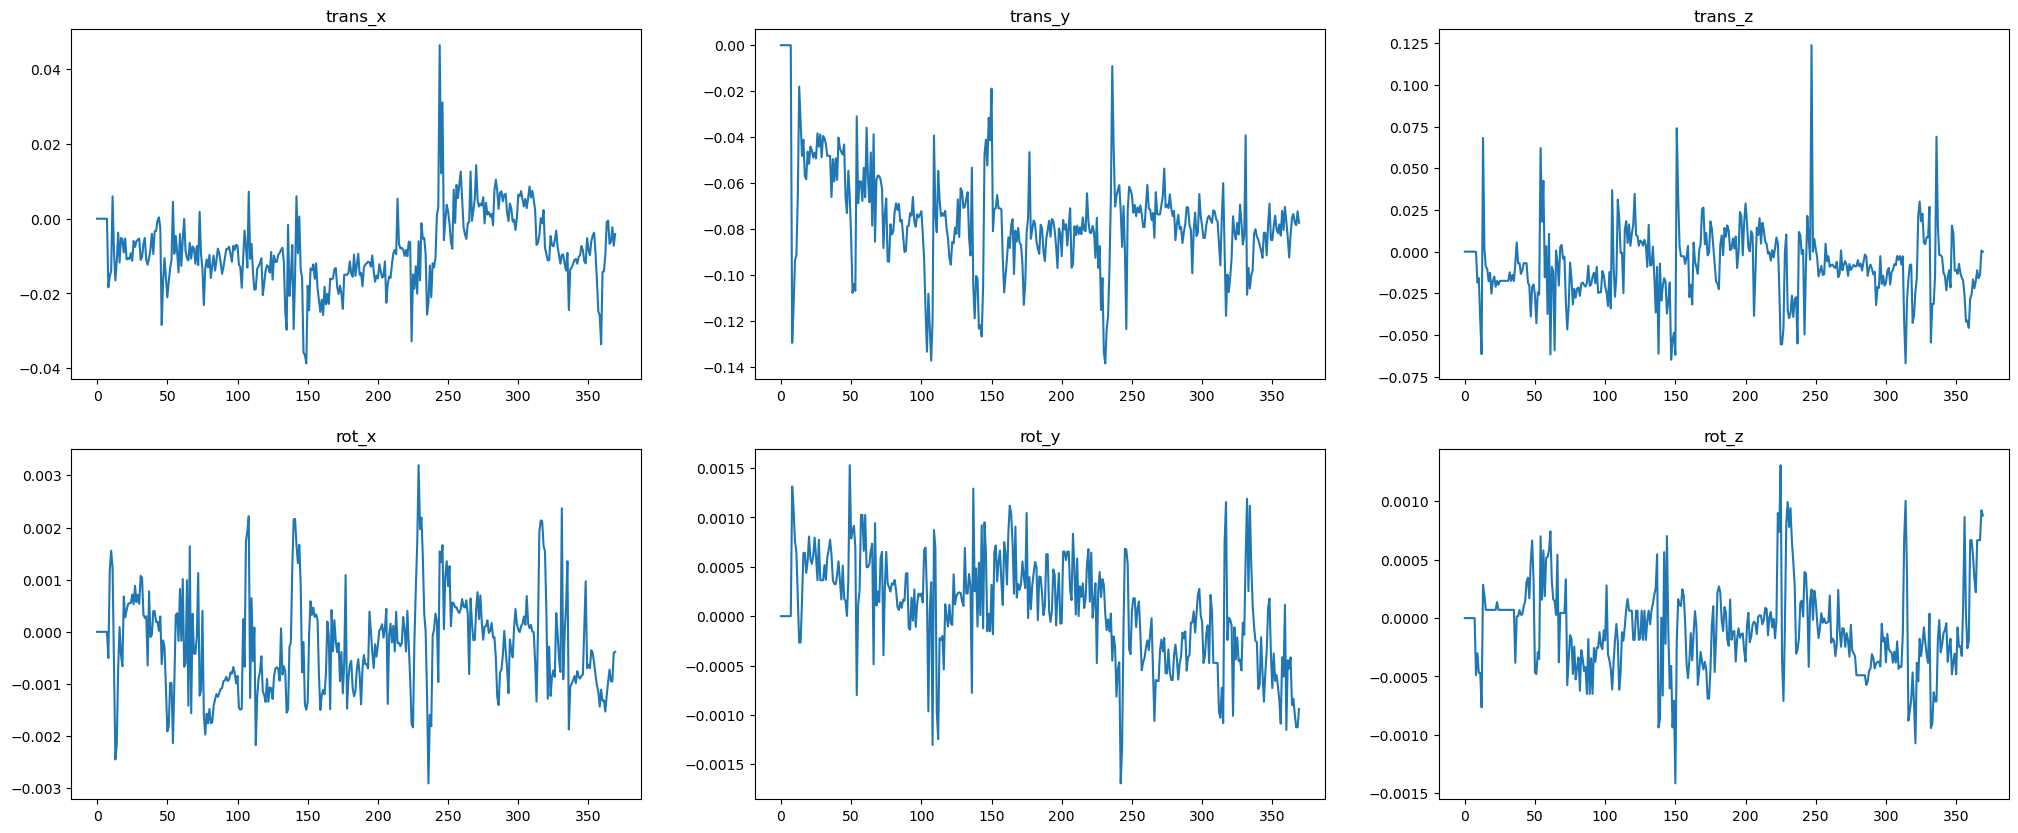

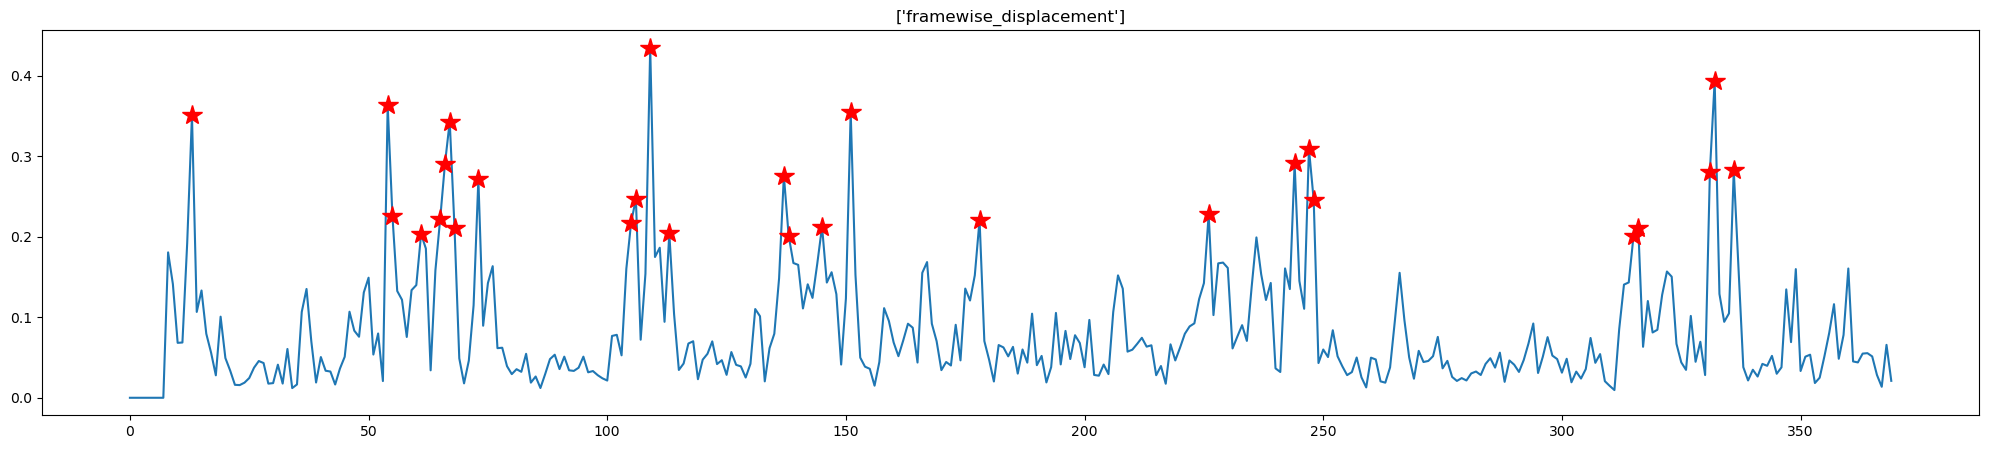

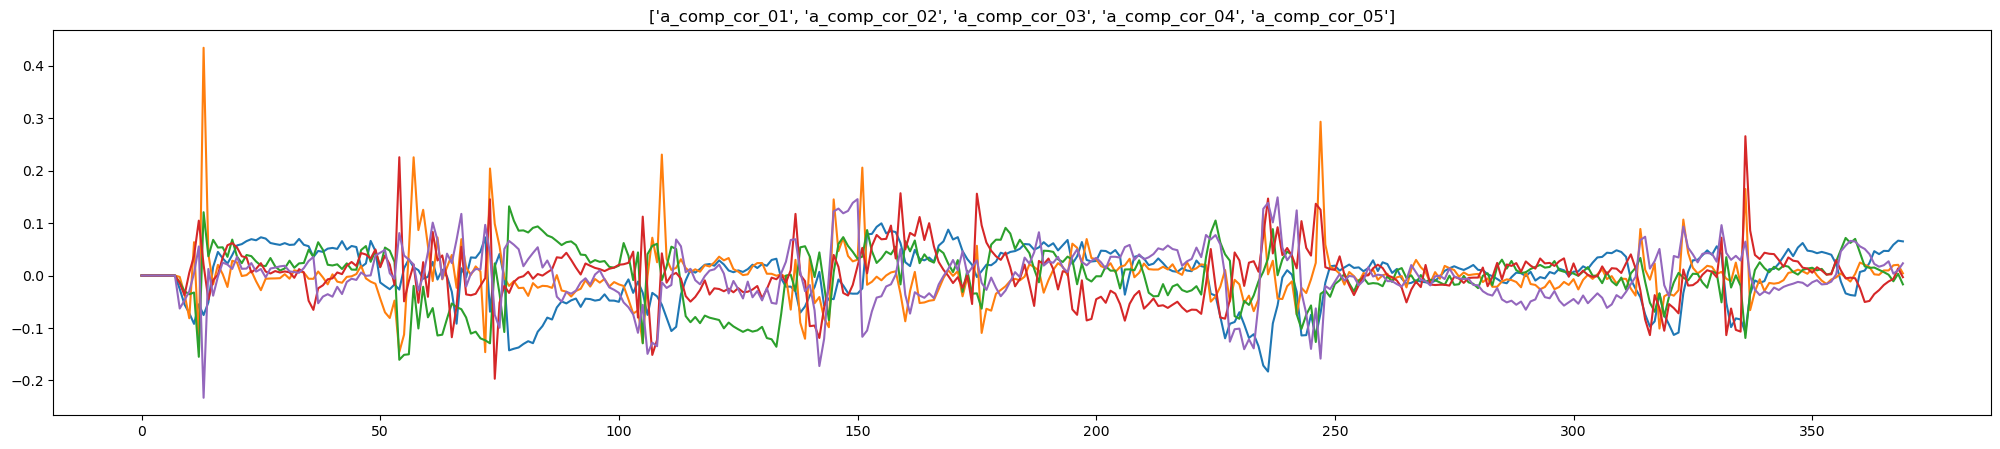

In [21]:
conf_keys = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
#conf_keys = ['X','Y','Z','RotX','RotY','RotZ']
plt.figure(figsize=(25,10))
nrows = 2
ncols = 3
sp=0
for key in conf_keys:
    sp=sp+1;plt.subplot(nrows,ncols,sp)
    plt.plot(df_conf[key].values)
    plt.title(key)
    
plt.figure(figsize=(25,5))
conf_keys = ['framewise_displacement']
#conf_keys = ['FramewiseDisplacement']
plt.plot(df_conf[conf_keys].values)
thresh=.2
vec = (df_conf[conf_keys].values>thresh)*1.0*df_conf[conf_keys].values
vec[vec==0]=np.nan
plt.plot(vec,'r*',markersize=15)
plt.title(conf_keys)

plt.figure(figsize=(25,5))
conf_keys = ['a_comp_cor_01','a_comp_cor_02',  'a_comp_cor_03',  'a_comp_cor_04','a_comp_cor_05']
#conf_keys = ['aCompCor01','aCompCor02',  'aCompCor03',  'aCompCor04','aCompCor05']
plt.plot(df_conf[conf_keys].values)
plt.title(conf_keys)

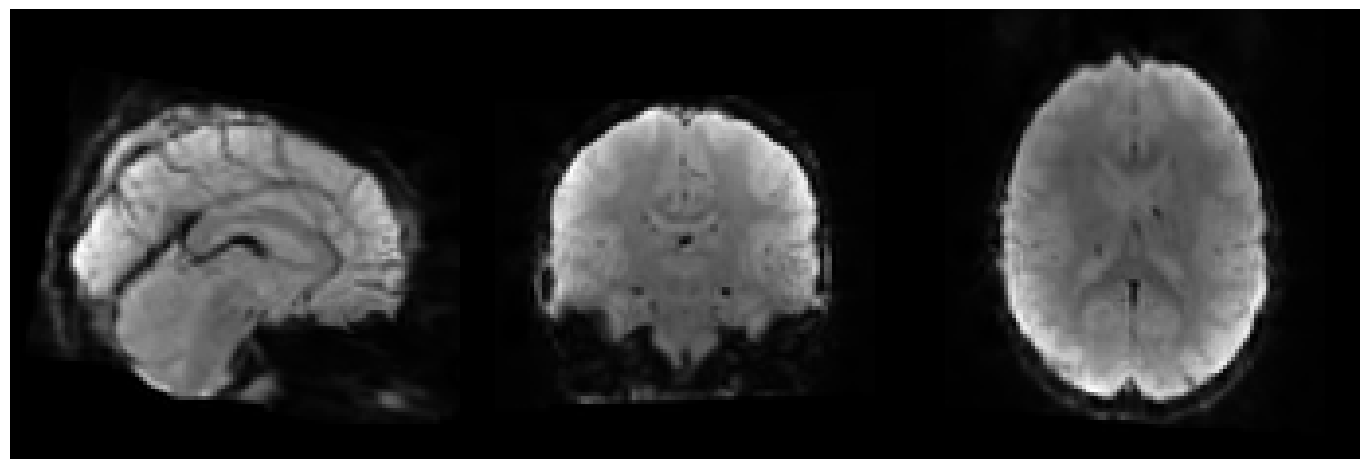

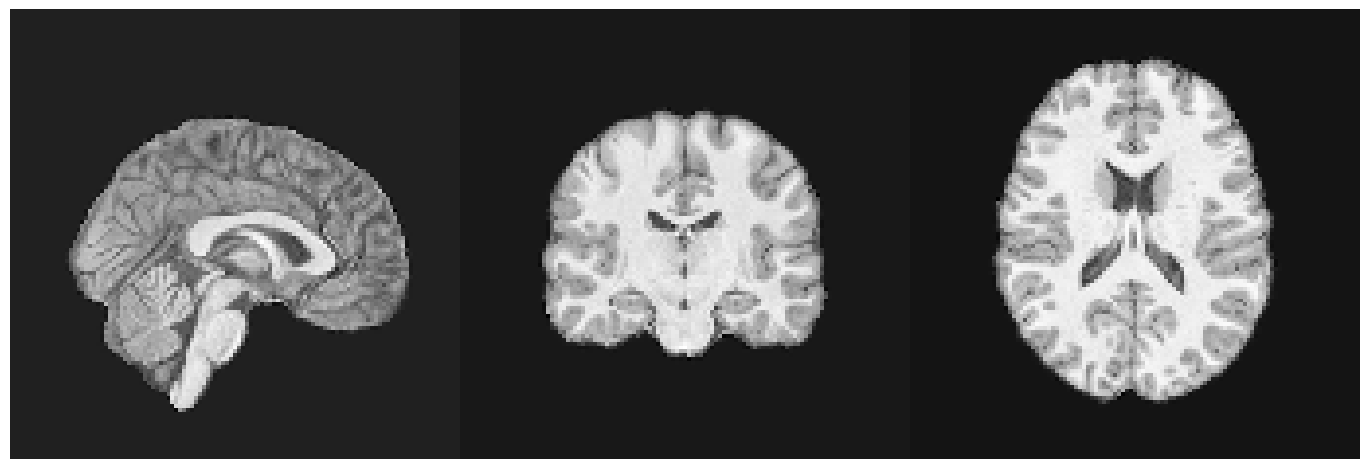

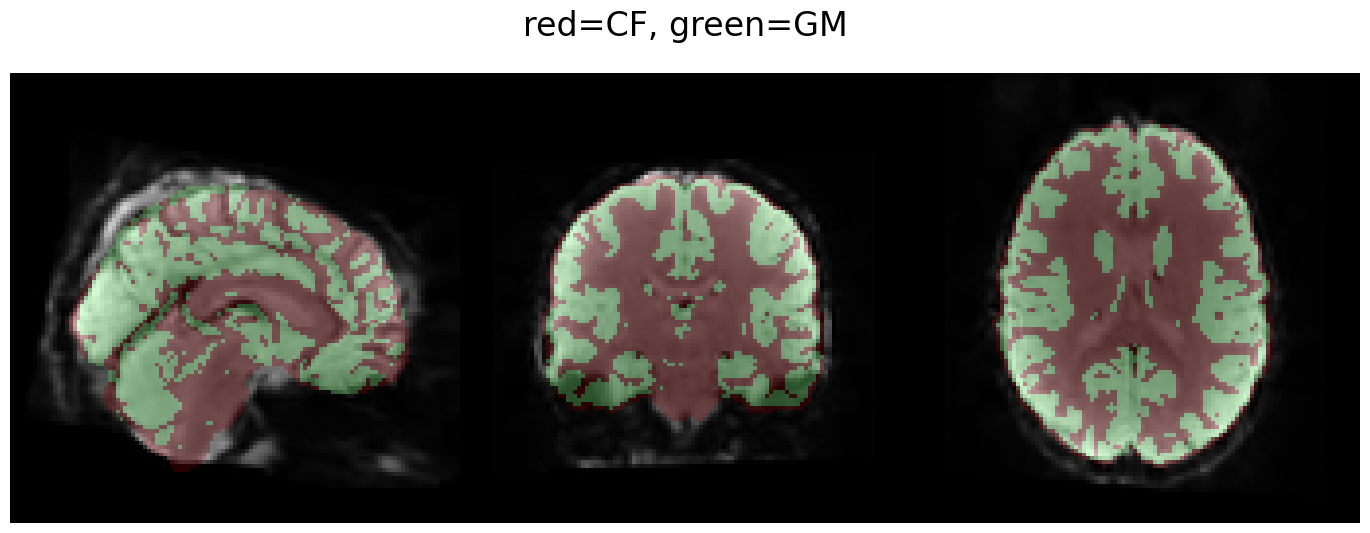

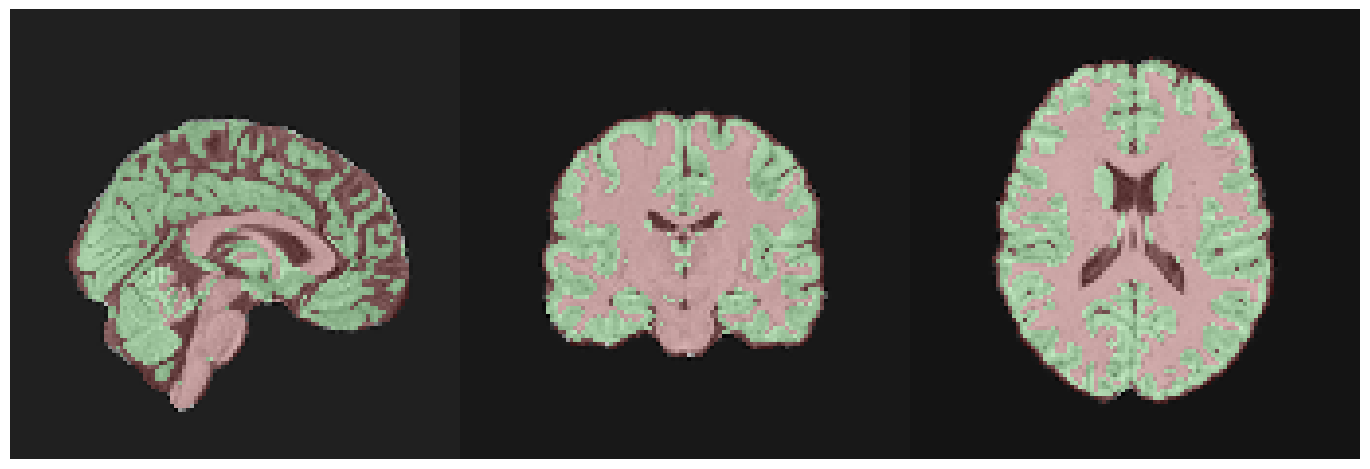

In [24]:
gm,cf = get_roi_and_roni(epi,anat,anat_gm,anat_wm,anat_csf,do_plot=True) # If using individual masks

In [25]:
obs_list_coords,noi_list_coords,gm,cf = get_obs_noi_list_coords(epi,gm,cf)

obs_list_coords.shape: (123813, 4, 370)
noi_list_coords.shape: (112676, 4, 370)
upsampling noi_list_coords
obs_list_coords.shape: (123813, 4, 370)
noi_list_coords.shape: (123813, 4, 370)


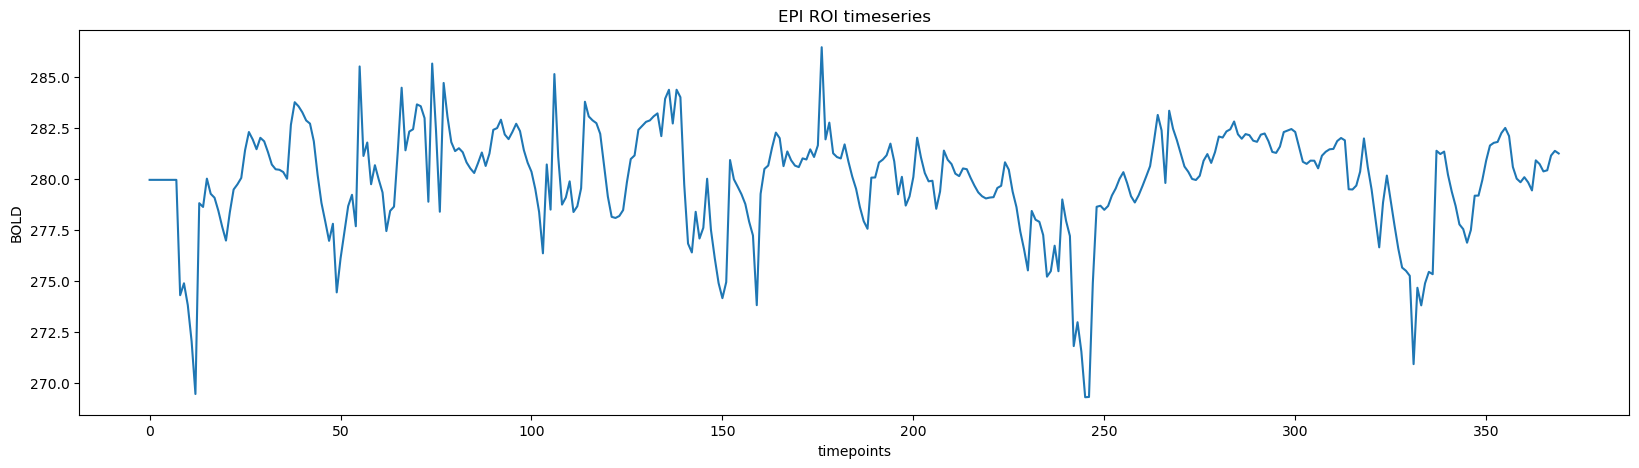

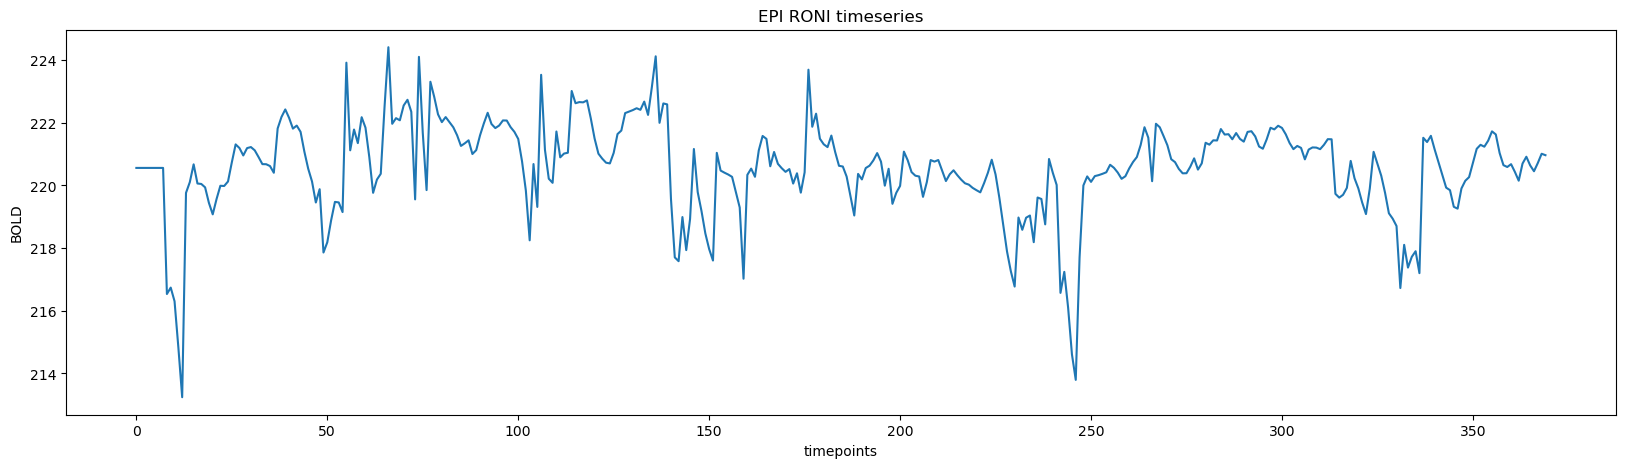

In [26]:
plot_timeseries(epi,gm,cf)

In [27]:
# Run some sanity check, for flat voxels (not good for training) and NaNs
assert np.isnan(obs_list_coords).sum()==0, 'NaNs in obs_list_coords'
assert np.isnan(noi_list_coords).sum()==0, 'NaNs in noi_list_coords'
assert (obs_list_coords[:,0,:].std(axis=-1)<1e-3).sum()==0,'Std0 in obs_list_coords'
assert (noi_list_coords[:,0,:].std(axis=-1)<1e-3).sum()==0,'Std0 in noi_list_coords'

In [28]:
# import importlib

# import DeepCor_utils
# importlib.reload(DeepCor_utils)

# import DeepCor_models

# importlib.reload(DeepCor_models)

# from DeepCor_utils import *
# from DeepCor_models import *

In [29]:
class cVAE_baseline(nn.Module):

    def __init__(self,in_channels: int,in_dim: int, latent_dim: int,beta: float,gamma: float,hidden_dims: List = None) -> None:
        super(cVAE_baseline, self).__init__()

        self.latent_dim = latent_dim
        self.in_channels = in_channels
        self.in_dim = in_dim
        self.beta = beta
        self.gamma = gamma
        self.sigmoid = nn.Sigmoid()

        modules_z = []
        if hidden_dims is None:
            hidden_dims = [64, 128, 256, 256]
        
        self.pad, self.final_size, self.pad_out = compute_padding(self.in_dim)

        # Build Encoder
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_z.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_z = nn.Sequential(*modules_z)
        self.fc_mu_z = nn.Linear(hidden_dims[-1]*int(self.final_size), latent_dim)
        self.fc_var_z = nn.Linear(hidden_dims[-1]*int(self.final_size), latent_dim)

        modules_s = []
        in_channels = self.in_channels
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_s.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_s = nn.Sequential(*modules_s)
        self.fc_mu_s = nn.Linear(hidden_dims[-1]*int(self.final_size), latent_dim)
        self.fc_var_s = nn.Linear(hidden_dims[-1]*int(self.final_size), latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(2*latent_dim, hidden_dims[-1] * int(self.final_size))

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose1d(hidden_dims[i],
                                    hidden_dims[i + 1],
                                    kernel_size=3,
                                    stride = 2,
                                    padding=int(self.pad_out[-4+i]),
                                    output_padding=int(self.pad_out[-4+i])),
                    nn.BatchNorm1d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )


        self.decoder = nn.Sequential(*modules)

        
        
        
        
        
        
        self.final_layer = nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=int(self.pad_out[-1]),
                                               output_padding=int(self.pad_out[-1])),
                            nn.BatchNorm1d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv1d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1))
           #out_channels

    def encode_z(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_z(input)
  
        result = torch.flatten(result, start_dim=1)


        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_z(result)
        log_var = self.fc_var_z(result)

        return [mu, log_var]

    def encode_s(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_s(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_s(result)
        log_var = self.fc_var_s(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1,256,int(self.final_size))
        result = self.decoder(result)
        result = self.final_layer(result)

        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward_tg(self, input: Tensor) -> List[Tensor]:
        tg_mu_z, tg_log_var_z = self.encode_z(input)
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        output = self.decode(torch.cat((tg_z, tg_s),1))
        return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]

    def forward_bg(self, input: Tensor) -> List[Tensor]:
        bg_mu_s, bg_log_var_s = self.encode_s(input)
        bg_s = self.reparameterize(bg_mu_s, bg_log_var_s)
        zeros = torch.zeros_like(bg_s)
        output = self.decode(torch.cat((zeros, bg_s),1))
        return  [output, input, bg_mu_s, bg_log_var_s]

    def forward_fg(self, input: Tensor) -> List[Tensor]:
        fg_mu_z, fg_log_var_z = self.encode_z(input)
        tg_z = self.reparameterize(fg_mu_z, fg_log_var_z)
        zeros = torch.zeros_like(tg_z)
        output = self.decode(torch.cat((tg_z, zeros),1))
        return  [output, input, fg_mu_z, fg_log_var_z]

    def loss_function(self,
                      *args,
                      ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        beta = self.beta
        gamma = self.gamma

        recons_tg = args[0]
        input_tg = args[1]
        tg_mu_z = args[2]
        tg_log_var_z = args[3]
        tg_mu_s = args[4]
        tg_log_var_s = args[5]
        tg_z = args[6]
        tg_s = args[7]
        recons_bg = args[8]
        input_bg = args[9]
        bg_mu_s = args[10]
        bg_log_var_s = args[11]

        #kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons_tg, input_tg)
        recons_loss += F.mse_loss(recons_bg, input_bg)
        # recons_loss *= input_shape[0]*input_shape[1]

        z1 = tg_z[:int(batch_size/2),:]
        z2 = tg_z[int(batch_size/2):,:]
        s1 = tg_s[:int(batch_size/2),:]
        s2 = tg_s[int(batch_size/2):,:]
        q_bar = torch.cat((torch.cat((s1,z2),1),torch.cat((s2,z1),1)),0)
        q = torch.cat((torch.cat((s1,z1),1),torch.cat((s2,z2),1)),0)
        #self.sigmoid = nn.Sigmoid()
        q_bar_score = self.sigmoid(q_bar)
        q_score = self.sigmoid(q)
        tc_batch = torch.log(q_score / (1.0 - q_score) + 1e-8)  # add eps for stability
        tc_loss  = tc_batch.mean()                              # average over batch

        kld_loss = 1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp()
        kld_loss += 1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp()
        kld_loss += 1 + bg_log_var_s - bg_mu_s ** 2 - bg_log_var_s.exp()
        kld_loss = torch.mean(-0.5 * torch.sum(kld_loss, dim = 1), dim = 0)

        loss = torch.mean(recons_loss + beta*kld_loss + gamma*tc_loss)

        return {'loss': loss, 'Reconstruction_Loss' : recons_loss , 'kld_loss': kld_loss, 'tc_loss' : tc_loss}

        
    def sample(self,
               num_samples:int,
               current_device: int) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """
        
        return self.forward_fg(x)[0]

<>:181: DeprecationWarning: invalid escape sequence \m
<>:181: DeprecationWarning: invalid escape sequence \m
/tmp/ipykernel_2527792/1701361784.py:181: DeprecationWarning: invalid escape sequence \m
  """


In [30]:
import traceback

nrep = hyperparams_cvae.get('nrep',20)
epoch_num = hyperparams_cvae.get('epoch_num',100)
batch_size = hyperparams_cvae.get('batch_size',512)
latent_dim = hyperparams_cvae.get('latent_dim',(8,8))
beta = hyperparams_cvae.get('beta',0.01)       
gamma = hyperparams_cvae.get('gamma',0)       
delta = hyperparams_cvae.get('delta',0)       
scale_MSE_GM = hyperparams_cvae.get('scale_MSE_GM',1e3)       
scale_MSE_CF = hyperparams_cvae.get('scale_MSE_CF',1e3)      
scale_MSE_FG = hyperparams_cvae.get('scale_MSE_FG',0) # "Denoised should be similar to input" scaling
lr = hyperparams_cvae.get('lr',0.001)

print(f'nrep: {nrep}')
print(f'epoch_num: {epoch_num}')
print(f'batch_size: {batch_size}')
print(f'latent_dim: {latent_dim}')
print(f'beta: {beta}')
print(f'gamma: {gamma}')
print(f'delta: {delta}')
print(f'scale_MSE_GM: {scale_MSE_GM}')
print(f'scale_MSE_CF: {scale_MSE_CF}')
print(f'scale_MSE_FG: {scale_MSE_FG}')
print(f'lr: {lr}')

#train_inputs_coords = TrainDataset(obs_list_coords,noi_list_coords)
train_inputs_coords = TrainDataset(obs_list_coords[:,0,:][:,np.newaxis,:],noi_list_coords[:,0,:][:,np.newaxis,:])
train_in_coords = torch.utils.data.DataLoader(train_inputs_coords, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)

global device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')
Tensor = TypeVar('torch.tensor')
conf_batch = torch.tensor(np.array([conf for _ in range(batch_size)])).to(device)

keys = ['l', 'kld_loss', 'recons_loss_roi', 'recons_loss_roni',
       'loss_recon_conf_s', 'loss_recon_conf_z', 'ncc_loss_tg',
       'ncc_loss_bg', 'ncc_loss_conf_s', 'ncc_loss_conf_z',
       'smoothness_loss', 'recons_loss_fg',  'batch_varexp',
        'tg_mu_z', 'tg_log_var_z', 'tg_mu_s', 'tg_log_var_s',
        'tg_z', 'tg_s', 'bg_log_var_z', 'bg_mu_z',
        'tg_log_var_z_mean','bg_log_var_z_mean','tg_log_var_s_mean',
        'tg_mu_z_std','bg_mu_z_std','tg_mu_s_std','batch_signal',
        'batch_noise','batch_in','batch_out','batch_varexp',
        'confounds_pred_z','confounds_pred_s',]


track = init_track(keys)
errors = []

for rep in tqdm(range(nrep)):
    try:
        track = init_track(keys)
        track['sub'] = sub
        track['s'] = s
        track['r'] = r
        track['ofdir'] = ofdir
        track['conf'] = conf
        track['rep'] = rep
        
        track_ofn = os.path.join(ofdir,f'track_S{s}_R{r}_rep_{rep}.pickle')
        model_ofn = os.path.join(ofdir,f'model_S{s}_R{r}_rep_{rep}.pickle')
        
        #model = cVAE(conf_batch,4,nTR,latent_dim, beta=beta, gamma=gamma,delta=delta,scale_MSE_GM=scale_MSE_GM,scale_MSE_CF=scale_MSE_CF,scale_MSE_FG=scale_MSE_FG,freq_exp=0,freq_scale=0,do_disentangle=True)
        model = cVAE_baseline(in_channels=1,in_dim=nTR,latent_dim=latent_dim,beta=beta,gamma=gamma)
        
        model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08)
        
        for epoch in range(epoch_num):  # loop over the dataset multiple times    
            model.train()
            dataloader_iter_in = iter(train_in_coords)
            track['epoch'] = epoch
            for i in range(len(train_in_coords)):
                optimizer.zero_grad()
                inputs_gm,inputs_cf = next(dataloader_iter_in)
    
                inputs_gm = inputs_gm.float().to(device)
                inputs_cf = inputs_cf.float().to(device)
    
                # inputs_gm = inputs_gm[:,0,:][:,torch.newaxis,:]
                # inputs_cf = inputs_cf[:,0,:][:,torch.newaxis,:]
    
                [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s] = model.forward_tg(inputs_gm)
                [outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z] = model.forward_bg(inputs_cf)
    
                loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s, outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z)
    
                if np.isnan(loss['loss'].detach().cpu().numpy()): raise ValueError(f'{rep}|{epoch}|{i}: loss is NaN') # If loss is NaNs, abort training and move on to the next repetition
                    
                loss['loss'].backward() # Do a backward pass
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Prevent gradient explosion
                optimizer.step()
                
            #track = update_track(track,model,inputs_gm,inputs_cf)
            #show_bashboard(track,single_fig=True)
            
        save_model(model_ofn,model,optimizer,epoch,loss)
        save_track(track_ofn,track)
        save_brain_signals(model,train_inputs_coords,epi,gm,ofn=os.path.join(ofdir,f'signal_S{s}_R{r}_rep_{rep}.nii.gz'),batch_size=512,kind='FG')
        save_brain_signals(model,train_inputs_coords,epi,gm,ofn=os.path.join(ofdir,f'recon_S{s}_R{r}_rep_{rep}.nii.gz'),batch_size=512,kind='TG') # Optional to save reconstructions
        save_brain_signals(model,train_inputs_coords,epi,gm,ofn=os.path.join(ofdir,f'noise_S{s}_R{r}_rep_{rep}.nii.gz'),batch_size=512,kind='BG') # Optional to save noise estimates                             
    
    except:
        errors.append(f'{rep}|{epoch}|{i}: loss is NaN')
        traceback.print_exc()
print('done training')
print(errors)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

nrep: 5
epoch_num: 5
batch_size: 1024
latent_dim: 8
beta: 0.01
gamma: 1
delta: 0
scale_MSE_GM: 1000.0
scale_MSE_CF: 1000.0
scale_MSE_FG: 0
lr: 0.001
device is cuda:0


 60%|██████████████████████████▍                 | 3/5 [07:00<04:40, 140.00s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_2527792/2222071877.py", line 77, in <module>
    inputs_gm,inputs_cf = next(dataloader_iter_in)
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1344, in _next_data
    return self._process_data(data)
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1368, in _process_data
    self._try_put_index()
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1350, in _try_put_index
    index = self._next_index()
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 620, in _next_index
    return next(self._sampler_iter)  # may ra

done training
['3|4|118: loss is NaN', '4|0|2: loss is NaN']


In [31]:
signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'signal_S{s}_R{r}_rep_'),f.endswith('.nii.gz')))]
track_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'track_S{s}_R{r}_rep_'),f.endswith('.pickle')))] 
signal_files.sort()
track_files.sort()
print('Ensemble of {} repetitions'.format(len(signal_files)))

Ensemble of 3 repetitions


In [32]:
signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'signal_S{s}_R{r}_avg.nii.gz'))

100%|█████████████████████████████████████████████| 3/3 [00:47<00:00, 15.97s/it]


signals averaged: 3


In [33]:
array_to_brain(obs_list_coords[:,0,:],epi,gm,os.path.join(ofdir,f'preproc_S{s}_R{r}.nii.gz'),inv_z_score=True,return_img=False)

In [34]:
compcor = calc_and_save_compcor(epi,gm,cf,os.path.join(ofdir,f'compcor_S{s}_R{r}.nii.gz'),n_components=5,return_img=True)

saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-baseline-test/corr2face_S15_R2_preproc.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-baseline-test/corr2face_S15_R2_compcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-baseline-test/corr2face_S15_R2_deepcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-baseline-test/corr2place_S15_R2_preproc.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-baseline-test/corr2place_S15_R2_compcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-baseline-test/corr2place_S15_R2_deepcor.nii.gz


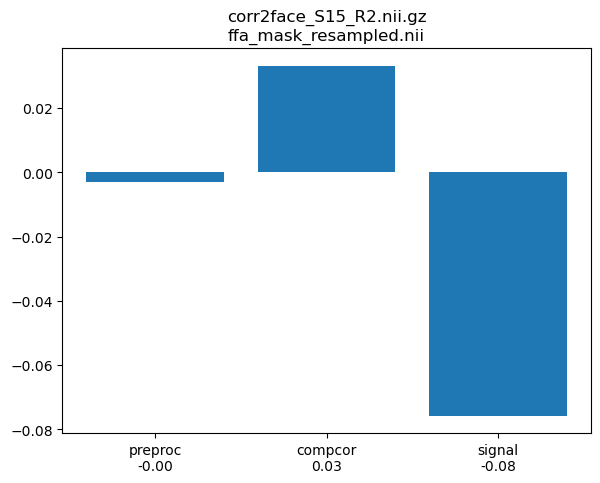

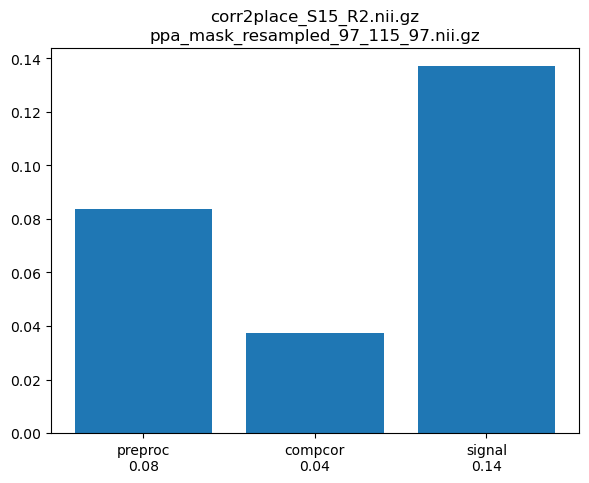

In [35]:
for analysis_spec in correlation_analyses:
    run_correlation_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-baseline-test/contrast_face_15_R2_preproc.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-baseline-test/contrast_face_15_R2_compcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-baseline-test/contrast_face_15_R2_deepcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-baseline-test/contrast_place_S15_R2_preproc.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-baseline-test/contrast_place_S15_R2_compcor.nii.gz
saved as: ../Data/StudyForrest/ensembles_last_CVAE/ABCD-baseline-test/contrast_place_S15_R2_deepcor.nii.gz


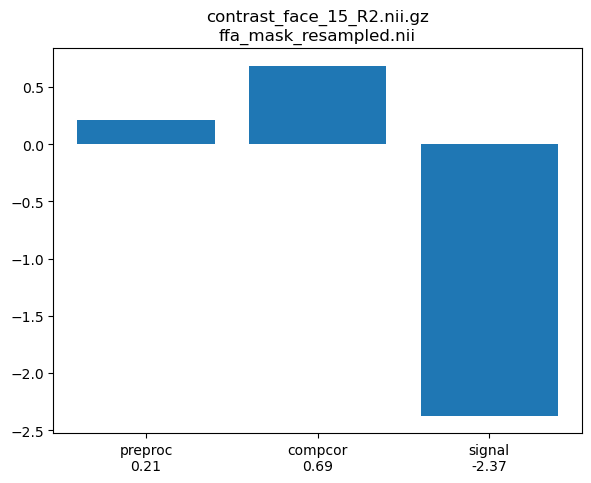

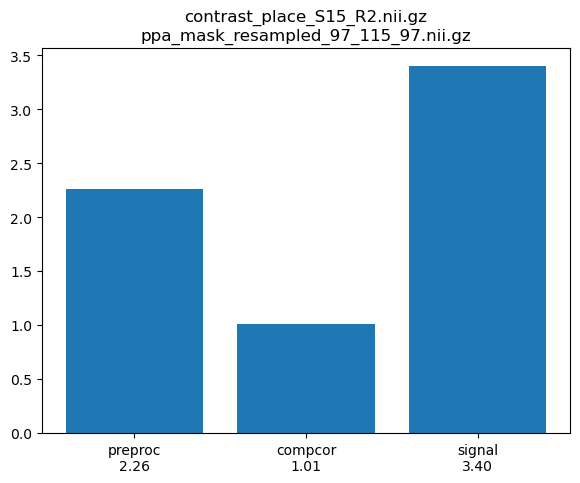

In [36]:
for analysis_spec in contrast_analyses:
    run_contrast_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

In [ ]:
# tracks = [load_pickle(track_file) for track_file in track_files]
# import warnings
# warnings.filterwarnings("ignore")
# plt.figure(figsize=(5*9,5*5))
# for track in tracks:
#     try:
#         show_bashboard(track,single_fig=False)
#     except:
#         print('bad track')